
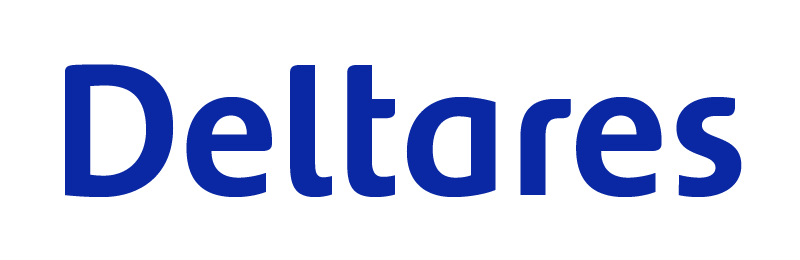


In this example, we'll work with an unstructured grid. We'll create a very
simple unstructured model of the Netherlands from scratch. We'll use a digital
elevation model (DEM) to set as drain level to simulate overland flow.
To this we add constant recharge.


Let's start with importing the required packages. 
These are [iMOD Python](https://deltares.github.io/imod-python/), [xarray](https://xarray.dev/), and [xugrid](https://deltares.github.io/xugrid/).

In [ ]:
import imod
import xarray as xr
import xugrid as xu


# Load the data

This data is distributed with the xugrid package. 
You need an internet connection to download the data.

In [ ]:

elevation = xu.data.elevation_nl()

elevation 

Let's plot the data

In [ ]:
elevation.ugrid.plot(vmin=-20, vmax=90, cmap="terrain")

# Template grid
It is convenient to create a *template* grid, which has the right shape,
dimensions, and coordinates. This can be used to construct DataArrays for
different variables.

We'll start off with creating a ``layer`` DataArray, which is a 1D DataArray,
containing all layer information required.


In [ ]:
layer = xr.DataArray(data=[1], coords={"layer": [1]}, dims=("layer",))

layer

Next, we'll create a 2D planar template grid. The xarray function ``.ones_like`` returns a new object of ones with the same shape and type as a given dataarray or dataset.

In [ ]:
template_2d = imod.typing.grid.ones_like(elevation, dtype=int)

template_2d

Finally, we'll create our unstructured template 3D grid.


We'll multiply our template 2d grid with the ``layer`` template to construct the
full 3D grid. Pay attention to the dimension order, iMOD Python is very specific
about this. We'll put the dimensions in the right order immediately, to save
ourselves headaches later.


In [ ]:
# iMOD Python requires the layer dimension first, faces dimension second
template = (template_2d * layer).transpose("layer", "mesh2d_nFaces")
# plot
template.sel(layer=1).ugrid.plot(vmin=0, vmax=2, cmap="viridis")

# Drainage

We can now use the template grid to transform the 2D elevation grid to a 3D
elevation grid, required for the drainage package.


In [ ]:
# Drain info
drainage_lvl = template * elevation  # requires layer dimension
# plot
drainage_lvl.sel(layer=1).ugrid.plot(vmin=-5, vmax=40, cmap="viridis")

Compute conductance. The function ``.ugrid.grid.area`` yields a numpy array with for each unstructured element its area (m2).
Multiplied with the unstructured grid with value 1 yiels grid with area. 

In [ ]:
cell_area = template * template.ugrid.grid.area # [m2]
resistance = 1  # [d]
conductance = cell_area / resistance # [m2/d]
# Plot
conductance.sel(layer=1).ugrid.plot()

# Discretization

Prepare our model discretization. ``idomain`` specifies whether a call is active
[1], inactive [0], or vertical pass through [-1]. In this case we'll go for a
grid that is active everywhere.


In [ ]:

idomain = template.copy()

We'll also define the bottom of the model. To keep things simple, we'll subtract
300 from the drainage level, which will also be our top. In this way, we'll
construct a model with thickness 300 everywhere.


In [ ]:
bottom = drainage_lvl - 300.0
# Plot
bottom.sel(layer=1).ugrid.plot()

# Recharge

Let's prepare our recharge. Note that Modflow 6 requires consistent length
units, so we have to provide recharge in m/d instead of mm/d!


In [ ]:
# Define recharge
recharge_rate = template * 0.002
# Plot
recharge_rate.sel(layer=1).ugrid.plot()

# Construct simulation

Initialization of the main MODFLOW 6 object. We give it a name. 

In [ ]:
simulation = imod.mf6.Modflow6Simulation("nl_elevation")

Within a ``Modflow6Simulation`` object one or more models can be defined. In this example there is just one ground water flow model. <br> In the next cells we will assemble our groundwater model in the object "gwf_model". Further down, we add it to the object "simulation". <br> 

In the next cell we define that option *newton* is chosen.  


In [ ]:
gwf_model = imod.mf6.GroundwaterFlowModel(newton=True)

The DIS package with vertices discretization needs input on tops, bottom and idomain.

In [ ]:
gwf_model["dis"] = imod.mf6.VerticesDiscretization(
    top=elevation, idomain=idomain, bottom=bottom
)

Assign storage package:

In [ ]:
gwf_model["sto"] = imod.mf6.SpecificStorage(
    specific_storage=1e-5, specific_yield=0.01, transient=False, convertible=1
)

Assign initial conditions, we'll set them equal to drainage level.

In [ ]:
gwf_model["ic"] = imod.mf6.InitialConditions(start=drainage_lvl)

The Node Property Flow is most noteworthy where we specify the hydraulic
conductivities. For a simple homogeneous, isotropic medium of 10 m/d:


In [ ]:
gwf_model["npf"] = imod.mf6.NodePropertyFlow(icelltype=1, k=10.0, k33=10.0)

Assign recharge package:

In [ ]:
gwf_model["rch"] = imod.mf6.Recharge(rate=recharge_rate)

Assign drainage package:

In [ ]:
gwf_model["drn"] = imod.mf6.Drainage(elevation=drainage_lvl, conductance=conductance)

In [ ]:
gwf_model["oc"] = imod.mf6.OutputControl(save_head="last", save_budget="last")

Now the ground water model object 'gwf_model' is ready. <br>
Let's add this model to the MODFLOW 6 simulation object. 

In [ ]:
simulation["gwf"] = gwf_model

The final things we have to define are specifying a solver settings and time discretization to the Modflow 6 simulation.

In [ ]:
simulation["solver"] = imod.mf6.SolutionPresetModerate(modelnames=["gwf"])

In [ ]:
simulation.create_time_discretization(additional_times=["2000-01-01", "2001-01-01"])

## Write model

In [ ]:
tmpdir = imod.util.temporary_directory()

modeldir = tmpdir / "reference"
simulation.write(modeldir)

Now run our simulation:

In [ ]:
# mf6_path = "path/to/mf6.exe" 

# If you installed Modflow6 in your PATH environment variable, you can use the
# following argument:
mf6_path = "mf6"

simulation.run(mf6_path)

Let's look at the results:

In [ ]:
head = simulation.open_head().load().isel(time=-1, layer=0)
# calculate ground water below surface level.
groundwater_depth = elevation - head
# Plot
groundwater_depth.ugrid.plot()

iMOD Python also supports partitioning a simulation, for parallel computation.
It offers convenience functions to split existing simulations.
For this we require a label array first.

In [ ]:
from imod.mf6.utilities.partition_generator import get_label_array

label_array = get_label_array(simulation, npartitions=4)

label_array.ugrid.plot()

Let's split our simulation with the label array.

In [ ]:
simulation_split = simulation.split(label_array)

Now write the split simulation and run it

In [ ]:
modeldir = tmpdir / "partitioned"
simulation_split.write(modeldir)
simulation_split.run(mf6_path)

And plot the results. Note that iMOD Python takes care of merging the 4
partitioned models into one single head grid.


In [ ]:
head_merged = simulation_split.open_head()["head"].isel(time=-1, layer=0)
# plot
head_merged.ugrid.plot(vmin=-20, vmax=90)